In [1]:
import pandas as pd
import numpy as np
from utils.methods import entropy
from utils.config import KeywordBy, base_path


# 这里提取企业数字化转型水平
keyword = [key for key in KeywordBy['数字化关键词_投资'] if key != '']
judge = lambda x: any([1 if key in x else 0 for key in keyword])
dataset = pd.read_excel(base_path / '无形资产数字化//FN_Fn022.xlsx', skiprows=[0, 2], dtype={'证券代码': 'object'})
dataset['截止日期'] = dataset['统计截止日期'].apply(lambda x: int(x[:4]))
dataset = dataset[(dataset['报表类型'] == 1) & (dataset['科目类别'] == 4)].reset_index(drop=True)
dataset['is_digital'] = dataset['无形资产项目'].apply(lambda x: int(judge(x)))
dataset['数字化无形资产净额'] = dataset['期末数'] * dataset['is_digital']
grouped_sum = dataset.groupby(['截止日期', '证券代码'])['数字化无形资产净额'].sum().reset_index()
grouped_sum = grouped_sum[grouped_sum['截止日期'] < 2024]

intangible = pd.read_excel(base_path / '无形资产数字化//FN_Fn020.xlsx', skiprows=[0, 2], dtype={'证券代码': 'object'})
intangible2 = pd.read_excel(base_path / '无形资产数字化//FN_Fn0201.xlsx', skiprows=[0, 2], dtype={'证券代码': 'object'})
dataset = pd.concat([intangible, intangible2], ignore_index=True)
dataset['截止日期'] = dataset['统计截止日期'].apply(lambda x: int(x[:4]))

dataset = dataset[(dataset['报表类型'] == 1) & (dataset['截止日期'] > 2006) & (dataset['科目类型'] == 3)].reset_index(drop=True)
dataset['is_digital'] = dataset['固定资产项目'].apply(lambda x: int(judge(x)))
dataset['数字化固定资产净额'] = dataset['期末余额'] * dataset['is_digital']
dataset = dataset.groupby(['截止日期', '证券代码'])['数字化固定资产净额'].sum().reset_index()
dataset = dataset[dataset['截止日期'] < 2024]
digital = pd.merge(grouped_sum, dataset, how='outer', on=['证券代码', '截止日期'])

# 读取资产总计
assets = pd.read_excel(base_path / '无形资产数字化//FS_Combas.xlsx', skiprows=[0, 2], dtype={'证券代码': 'object', '统计截止日期': 'datetime64[s]'})
assets['截止日期'] = assets['统计截止日期'].dt.year
assets['截止日期'] = assets['截止日期'].astype('int')
assets = assets[(assets['报表类型'] == 'A') & (assets['统计截止日期'].dt.month == 12)&(assets['统计截止日期'].dt.year > 2006)]
assets = assets[['证券代码', '截止日期', '资产总计']]
digital = pd.merge(digital, assets, how='outer', on=['证券代码', '截止日期'])
digital['无形资产数字化'] = digital['数字化无形资产净额'] / digital['资产总计']
digital['固定资产数字化'] = digital['数字化固定资产净额'] / digital['资产总计']

# 计算企业数字化指数
digital.rename(columns={'证券代码': '股票代码'}, inplace=True)
digital = digital[digital['截止日期'] > 2010]
# digital.head(10)

,截止日期,股票代码,数字化无形资产净额,数字化固定资产净额,资产总计,无形资产数字化,固定资产数字化
4,2011,000001,3.758920e+08,0.0,1.258177e+12,0.000299,0.0
5,2012,000001,5.527070e+08,0.0,1.606537e+12,0.000344,0.0
6,2013,000001,4.230000e+08,0.0,1.891741e+12,0.000224,0.0
7,2014,000001,5.390000e+08,0.0,2.186459e+12,0.000247,0.0
8,2015,000001,4.960000e+08,0.0,2.507149e+12,0.000198,0.0
9,2016,000001,5.950000e+08,0.0,2.953434e+12,0.000201,0.0
10,2017,000001,8.130000e+08,0.0,3.248474e+12,0.000250,0.0
11,2018,000001,1.172000e+09,0.0,3.418592e+12,0.000343,0.0
12,2019,000001,1.050000e+09,0.0,3.939070e+12,0.000267,0.0
13,2020,000001,8.280000e+08,0.0,4.468514e+12,0.000185,0.0


In [2]:
dataset = pd.read_csv(base_path / 'MDA管理层讨论与分析.csv', encoding='utf8', index_col=None, header=0, dtype={'股票代码': 'object'})
dataset = dataset[dataset['截止日期'] > 2010]
# 吴非法/胡元林法
wufei = KeywordBy['wufei']
huyuanlin = KeywordBy['吴非']
for key, keyword in huyuanlin.items():
    dataset[key] = dataset[keyword].apply(lambda x: x.sum(), axis=1)

dataset['wufei'] = dataset[huyuanlin.keys()].apply(lambda x: x.sum(), axis=1)
dataset['wufei'] = dataset['wufei'].apply(lambda x: np.log(x + 1))
# 袁淳法
yuanchun = KeywordBy['袁淳']
dataset['yuanchun'] = dataset[yuanchun].apply(lambda x: x.sum(), axis=1)
dataset['yuanchun'] = dataset['yuanchun'] / dataset['mda总词数']
dataset['yuanchun'] = dataset['yuanchun'] * 100

# 李寿喜
names = ['人工智能技术', '大数据技术', '云计算技术', '区块链技术', '数字技术运用']
lishouxi = dataset[['股票代码', '截止日期', *names]].copy(deep=True)
for key in names:
    lishouxi[key] = lishouxi[key].apply(lambda x: np.log(x + 1))
lishouxi = pd.merge(lishouxi, digital, how='outer', on=['股票代码', '截止日期']).fillna(0).sort_values(['股票代码', '截止日期'])
lishouxi = lishouxi.drop(['数字化无形资产净额', '数字化固定资产净额', '资产总计'], axis=1).set_index(['股票代码', '截止日期'])

lishouxi['lishouxi'] = lishouxi.dot(entropy(lishouxi))
lishouxi.reset_index(inplace=True)
dataset = pd.merge(dataset, lishouxi[['股票代码', '截止日期', '无形资产数字化', '固定资产数字化', 'lishouxi']], how='outer', on=['股票代码', '截止日期'])

# 赵辰宇法
_zhaochenyv = KeywordBy['赵宸宇']
for key, keyword in _zhaochenyv.items():
    dataset[key] = dataset[keyword].apply(lambda x: x.sum(), axis=1)

zhaochenyv = dataset[['股票代码', '截止日期', *_zhaochenyv.keys()]]
zhaochenyv = zhaochenyv.sort_values(['股票代码', '截止日期']).set_index(['股票代码', '截止日期'])

zhaochenyv['zhaochenyv'] = zhaochenyv.dot(entropy(zhaochenyv))
zhaochenyv.reset_index(inplace=True)
dataset = pd.merge(dataset, zhaochenyv[['股票代码', '截止日期', 'zhaochenyv']], how='outer', on=['股票代码', '截止日期'])
dataset['zhaochenyv'] = (dataset['zhaochenyv'] + (dataset['无形资产数字化'] + dataset['固定资产数字化']) * 1.5) / 2
# 读取来自于csmar的测度结果
csmar = pd.read_excel(base_path / 'csmar/EDT_DigTransIndexStaY.xlsx', skiprows=[0, 2], dtype={'证券代码': 'object'})[
    ['证券代码', '统计年度', '数字化转型指数']]
csmar.rename(columns={'证券代码': '股票代码', '统计年度': '截止日期', '数字化转型指数': 'csmar'}, inplace=True)
dataset = pd.merge(csmar, dataset, how='outer', on=['股票代码', '截止日期'])
# 删除管理层文本并保存结果
dataset.drop(['讨论与分析内容'], axis=1, inplace=True)
dataset.head(10)

,股票代码,截止日期,csmar,智能设备,数据可视化,数控,一体化,未来工厂,联网,数字营销,...,wufei,yuanchun,无形资产数字化,固定资产数字化,lishouxi,数字技术应用z,互联网商业模式z,智能制造z,现代信息系统z,zhaochenyv
0,000001,2011,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,2.768166,0.000299,0.0,-0.000001,0.0,0.0,0.0,1.0,0.105716
1,000001,2012,37.3088,0.0,0.0,0.0,2.0,0.0,1.0,0.0,...,0.693147,1.404191,0.000344,0.0,0.112228,1.0,4.0,2.0,1.0,1.109769
2,000001,2013,46.7503,0.0,0.0,0.0,3.0,0.0,16.0,0.0,...,2.890372,1.914063,0.000224,0.0,0.604352,1.0,8.0,3.0,1.0,1.895150
3,000001,2014,44.9374,0.0,0.0,0.0,4.0,0.0,36.0,0.0,...,3.496508,2.971819,0.000247,0.0,0.811316,7.0,14.0,6.0,1.0,4.017315
4,000001,2015,47.0873,0.0,0.0,0.0,2.0,0.0,38.0,0.0,...,3.526361,4.002450,0.000198,0.0,1.577692,18.0,14.0,2.0,2.0,5.302312
5,000001,2016,48.9749,0.0,0.0,0.0,2.0,0.0,17.0,0.0,...,3.178054,3.651473,0.000201,0.0,1.144505,12.0,7.0,10.0,3.0,4.007659
6,000001,2017,57.2778,0.0,0.0,0.0,2.0,0.0,10.0,0.0,...,3.583519,4.703528,0.000250,0.0,1.553090,20.0,12.0,16.0,3.0,6.472614
7,000001,2018,56.5303,0.0,0.0,0.0,2.0,0.0,26.0,0.0,...,4.574711,7.784986,0.000343,0.0,2.963407,57.0,19.0,36.0,5.0,14.613916
8,000001,2019,52.5442,0.0,0.0,0.0,7.0,0.0,20.0,0.0,...,4.584967,7.202129,0.000267,0.0,2.929113,57.0,16.0,47.0,2.0,14.667463
9,000001,2020,53.9022,0.0,0.0,0.0,11.0,0.0,22.0,0.0,...,4.465908,6.613892,0.000185,0.0,2.725289,61.0,11.0,36.0,2.0,13.437308


In [3]:
from scipy.stats.mstats import winsorize

keywords = ['wufei', 'zhaochenyv', 'yuanchun', 'lishouxi', '固定资产数字化', '无形资产数字化', '数字技术应用z', '互联网商业模式z', '智能制造z','现代信息系统z',  'csmar']
digital = dataset[['股票代码', '截止日期', *keywords]].copy(deep=True)
digital.sort_values(['股票代码', '截止日期'], inplace=True)
for keyword in keywords:
        # 此处判断是否空值，是的话为空，否的话进行屏蔽空值和无效值的1%和99%缩尾处理
        digital[keyword] = np.where(digital[keyword].isnull(), np.nan,
                                    winsorize(np.ma.masked_invalid(digital[keyword]), limits=(0.01, 0.01)))
digital = digital.sort_values(['股票代码', '截止日期']).reset_index(drop=True)
info_columns = ['Symbol', 'ShortName', 'EndDate', 'IndustryCodeD', 'LISTINGDATE', 'PROVINCE', 'LISTINGSTATE']
data = pd.read_csv(base_path / '上市公司基本信息年度.csv', dtype={'Symbol': 'object'}, parse_dates=['EndDate', 'EstablishDate', 'LISTINGDATE'])[info_columns]

data = data[(data['EndDate'].dt.year > 2013) * (data['EndDate'].dt.month == 12)]
data['EndDate'] = data['EndDate'].dt.year.astype('int')
data.rename(columns={'Symbol': '股票代码', 'ShortName': '股票简称', 'EndDate': '截止日期', 'IndustryCodeD': '行业代码', 'LISTINGDATE': '上市日期', 'PROVINCE': '所属省份', 'LISTINGSTATE': '上市状态'}, inplace=True)
data['行业代码'] = data['行业代码'].apply(lambda x: int(x[1:]))
# 筛选出制造企业，23年是制造业的话，应保留其数据
stocks = data[(data['截止日期'] == 2023) & (data['行业代码'] > 12) & (data['行业代码'] < 44) & (data['行业代码'] != 39)]['股票代码'].tolist()
_keeps = []
for stock in stocks:
    # 如果某个企业最大上市日期不是2023则删除
    cdata = digital[(digital['股票代码'] == stock) & (digital['截止日期'] > 2019)].sort_values(["截止日期"])
    if max(cdata['截止日期']) == 2023:
        _keeps.append(stock)
data = data[data['股票代码'].isin(_keeps)].sort_values(["股票代码", "截止日期"]).reset_index(drop=True)
digital = digital[(digital['截止日期'] > 2013) & (digital['股票代码'].isin(_keeps))]
data = pd.merge(data, digital, how='outer', on=['股票代码', '截止日期'])
# 对数据进行填充
data = data[~data['股票简称'].isna()]
data.to_csv('./data/数字化单位及数字化程度(未筛选).csv', encoding='utf8', index=False)

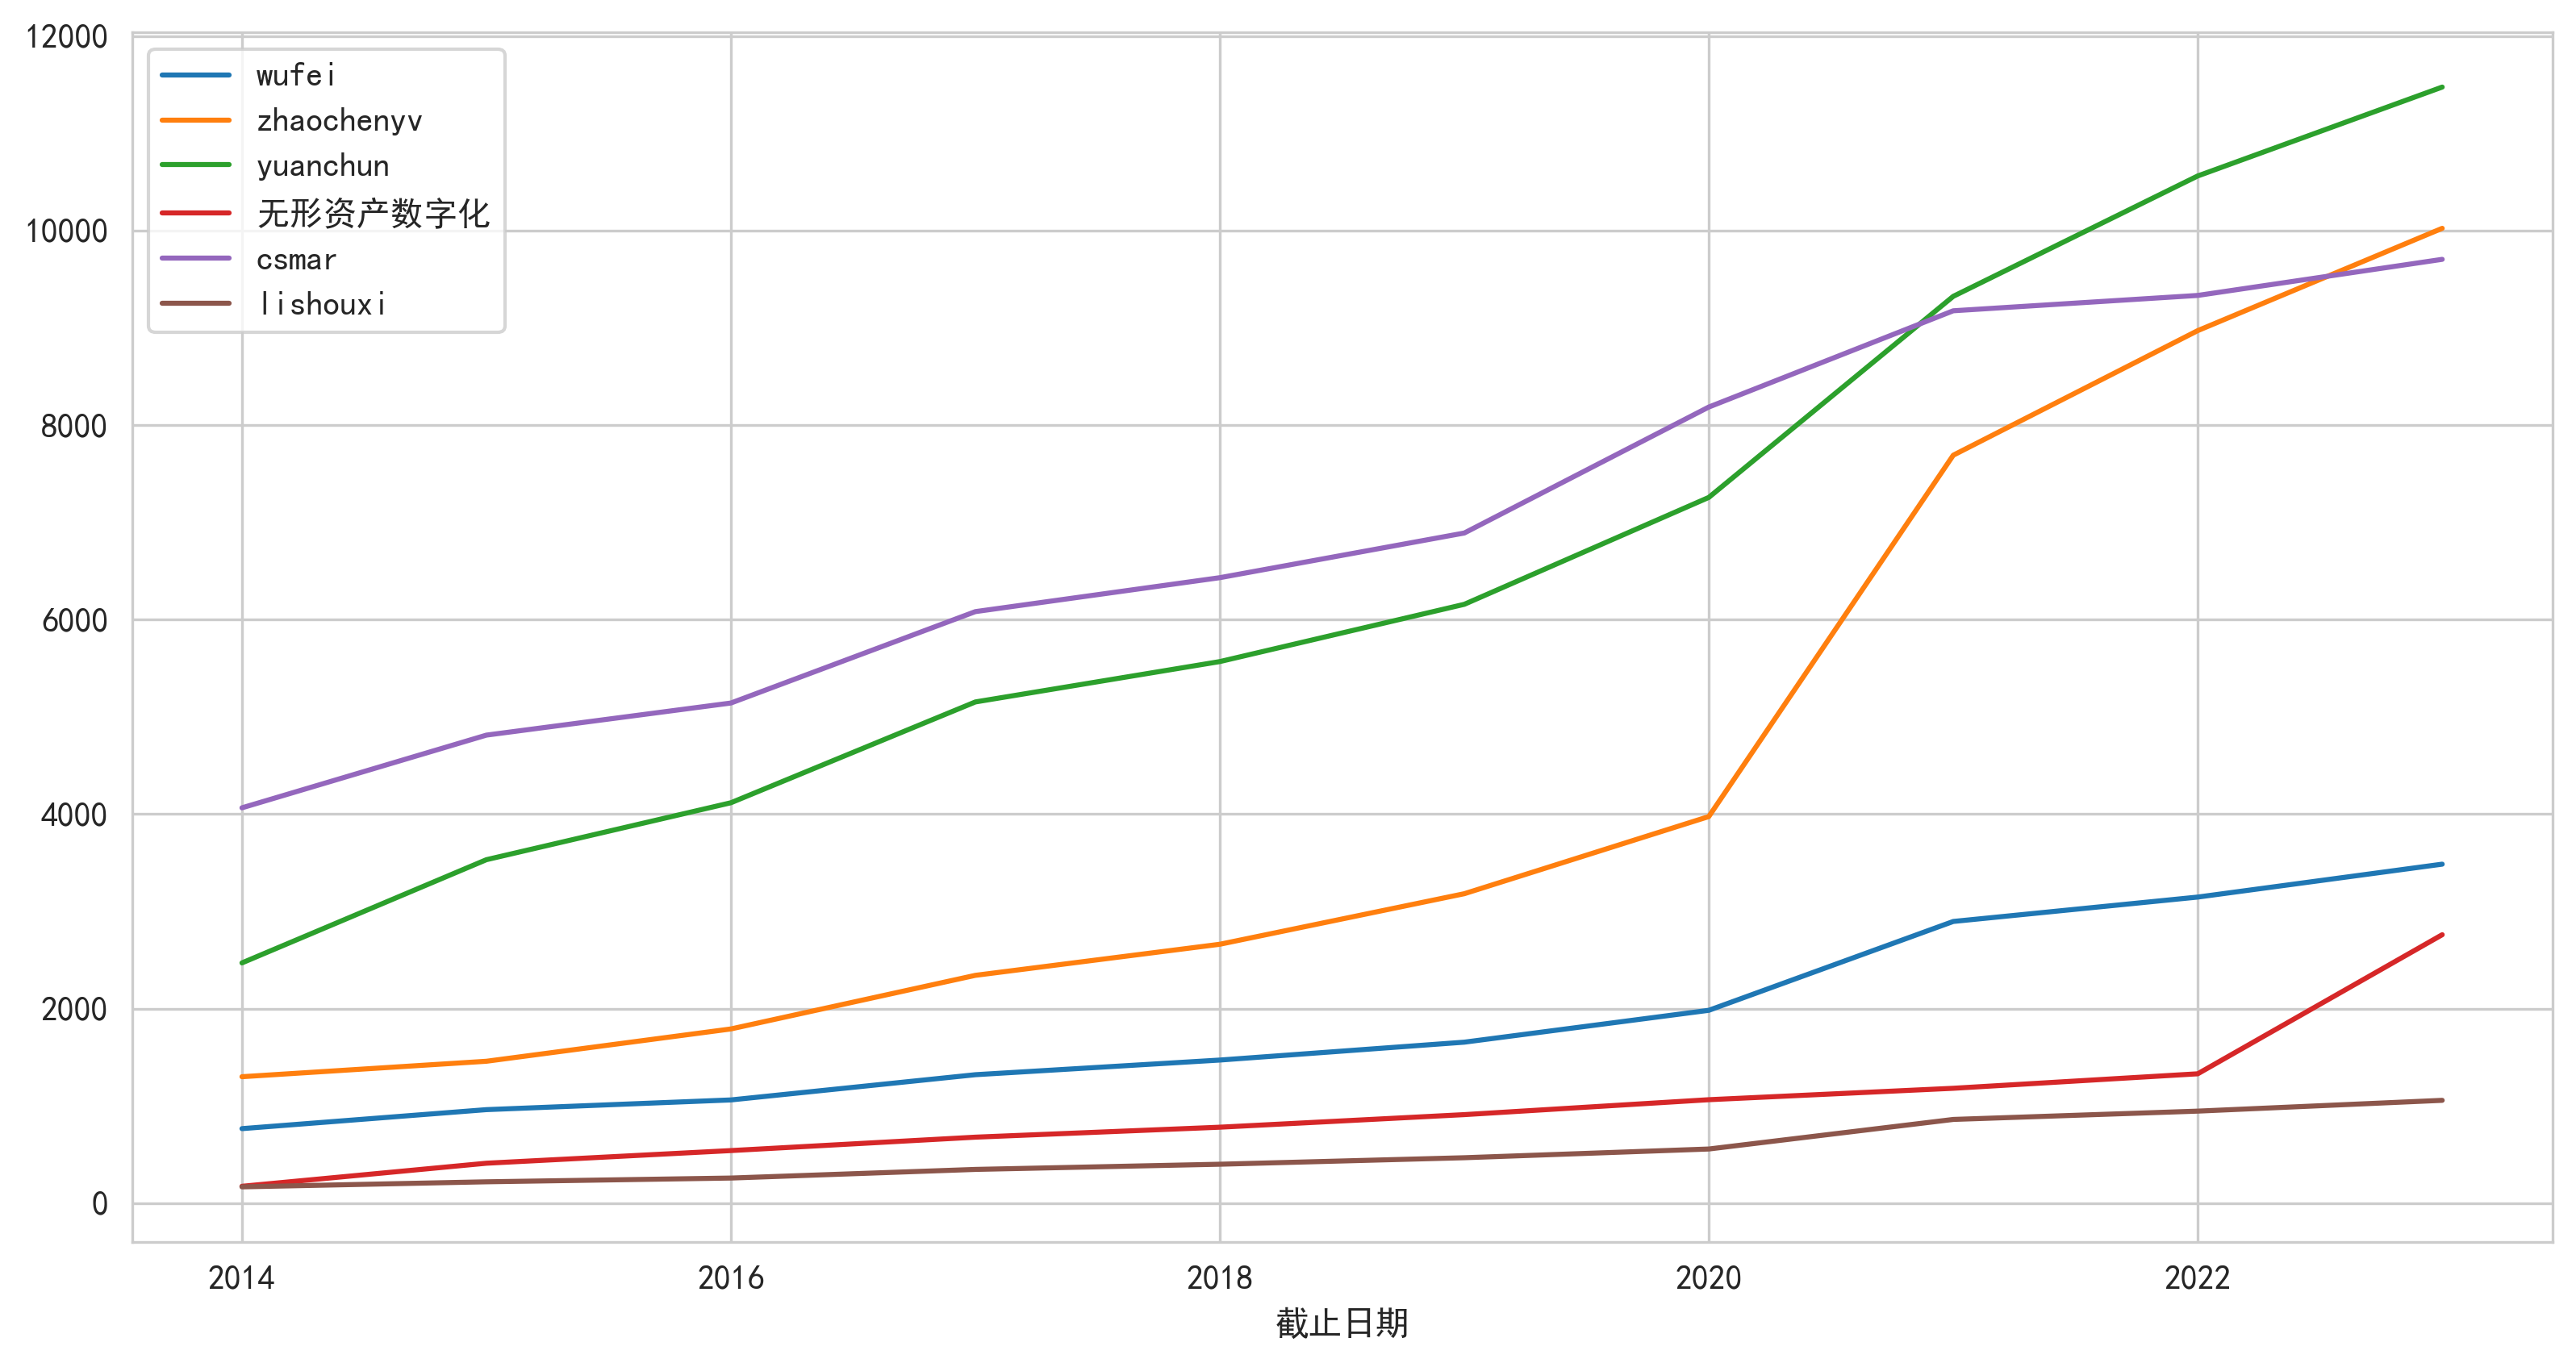

In [4]:
import pandas as pd
import matplotlib.pylab as plt
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False    # 用来正常显示负号

dataset = pd.read_csv(r'./data/数字化单位及数字化程度(未筛选).csv', dtype={'股票代码':'object'})
fig = plt.figure(figsize=(10, 5), dpi=300)
ax = fig.add_axes([0, 0, 1, 1])
names = ['截止日期', 'wufei', 'zhaochenyv', 'yuanchun', '无形资产数字化', 'csmar','lishouxi']
# 对数据进行一定程度的缩放，让其能够在一个图上显示出来
_dataset = dataset[names].copy(deep=True)
_dataset['无形资产数字化'] = _dataset['无形资产数字化']*300
_dataset['csmar'] = _dataset['csmar']/10
digital = _dataset[names].groupby('截止日期').sum()
digital.plot(ax=ax)
plt.legend()
plt.show()